In [1]:
"""
@author: Zongyi Li
This file is the Fourier Neural Operator for 1D problem such as the (time-independent) Burgers equation discussed in Section 5.1 in the [paper](https://arxiv.org/pdf/2010.08895.pdf).
"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *

from Adam import Adam

In [2]:
torch.manual_seed(0)
np.random.seed(0)


################################################################
#  1d fourier layer
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        #Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.padding = 2 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(2, self.width) # input channel is 2: (a(x), x)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 2, 1)
        # x = F.pad(x, [0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        # x = x[..., :-self.padding] # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)

In [3]:
################################################################
#  configurations
################################################################
ntrain = 1000
ntest = 100

sub = 2**3 #subsampling rate
h = 2**13 // sub #total grid size divided by the subsampling rate
s = h

batch_size = 20
learning_rate = 0.001

epochs = 500
step_size = 50
gamma = 0.5

modes = 64
width = 64

In [114]:
dataloader = MatReader('data/burgers_self.mat') 
x_data = dataloader.read_field('input')[:,:]
y_data = dataloader.read_field('u_results')[:,:]

x_train = x_data[:ntrain,:]
y_train = y_data[:ntrain,:]
x_test = x_data[-ntest:,:]
y_test = y_data[-ntest:,:]

x_train = x_train.reshape(ntrain,s,1)
x_test = x_test.reshape(ntest,s,1)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

# model
model = FNO1d(modes, width).cuda()
print(count_params(model))

2122433


In [104]:
dataloader = MatReader('data/burgers_self_smallerdt.mat')
x_data = dataloader.read_field('input')[:,:] 
y_data = dataloader.read_field('u_results')[:,:]

x_train = x_data[:ntrain,:]
y_train = y_data[:ntrain,:]
x_test = x_data[-ntest:,:]
y_test = y_data[-ntest:,:]

x_train = x_train.reshape(ntrain,s,1)
x_test = x_test.reshape(ntest,s,1)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

# model
model = FNO1d(modes, width).cuda()
print(count_params(model))

1073857


In [51]:
dataloader = MatReader('data/burgers_self_lowvisc.mat')
x_data = dataloader.read_field('input')[:,:] 
y_data = dataloader.read_field('u_results')[:,:]

x_train = x_data[:ntrain,:]
y_train = y_data[:ntrain,:]
x_test = x_data[-ntest:,:]
y_test = y_data[-ntest:,:]

x_train = x_train.reshape(ntrain,s,1)
x_test = x_test.reshape(ntest,s,1)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

# model
model = FNO1d(modes, width).cuda()
print(count_params(model))

16802497


In [115]:
################################################################
# training and evaluation
################################################################
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = LpLoss(size_average=False)
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x)

        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward() # use the l2 relative loss

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()

            out = model(x)
            test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest

    t2 = default_timer()
    print(ep, t2-t1, train_mse, train_l2, test_l2)

# torch.save(model, 'model/ns_fourier_burgers')
pred = torch.zeros(y_test.shape)
index = 0
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=1, shuffle=False)
with torch.no_grad():
    for x, y in test_loader:
        test_l2 = 0
        x, y = x.cuda(), y.cuda()

        out = model(x).view(-1)
        pred[index] = out

        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        print(index, test_l2)
        index = index + 1

#scipy.io.savemat('pred/burger_test.mat', mdict={'pred': pred.cpu().numpy()})

0 0.6943187648430467 0.013215660322457553 0.6482451496124267 0.4810357570648193
1 0.6931972438469529 0.0034829709399491547 0.3418246350288391 0.24713251113891602
2 0.6857137000188231 0.001219727931311354 0.2063322637081146 0.16939849615097047
3 0.6804255787283182 0.0006581087311496958 0.15152573704719544 0.13378624200820924
4 0.6819340940564871 0.0004334982158616185 0.12215932178497314 0.11446977853775024
5 0.6791781596839428 0.00031442611856618896 0.1016694575548172 0.09875730156898499
6 0.6769608799368143 0.00021841984387720005 0.08489019632339477 0.08928972005844116
7 0.6772809885442257 0.00019612433155998587 0.07991777980327607 0.07637517094612122
8 0.6776761300861835 0.00020392668244312518 0.08160479807853699 0.09920411586761474
9 0.6784275807440281 0.0001472989289322868 0.06957429897785186 0.07014335632324219
10 0.6780039397999644 0.00010985405984683893 0.05962411838769913 0.06359990239143372
11 0.6822912022471428 9.437757835257798e-05 0.0553726794719696 0.06300633907318115
12 0.

97 0.6820160681381822 4.8273996299030845e-06 0.012632169216871261 0.017937702536582948
98 0.6788660706952214 6.178655567055102e-06 0.014073474884033203 0.019354777932167052
99 0.6791773764416575 7.083632922331162e-06 0.014687704622745514 0.022430365383625032
100 0.6763328034430742 2.9863965050935804e-06 0.009595468819141388 0.01597072750329971
101 0.6776084844022989 2.5910573958753956e-06 0.009006071075797081 0.017665748298168183
102 0.6852138713002205 2.092024967623729e-06 0.008331205487251282 0.015606977343559265
103 0.6785172838717699 1.981662740035972e-06 0.007920345202088355 0.0152334463596344
104 0.6796464119106531 2.377706409788516e-06 0.00877947049587965 0.016322323977947237
105 0.6862957086414099 1.7778092797016144e-06 0.007654012411832809 0.01568475216627121
106 0.6709821121767163 1.8675265550882615e-06 0.00780628776550293 0.015590770244598389
107 0.6661631586030126 2.122661326211528e-06 0.00820722483843565 0.015176958739757537
108 0.6685425387695432 2.222850937414478e-06 0.0

192 0.7185868406668305 6.199417049401746e-07 0.004437996797263622 0.012603674530982972
193 0.7151578804478049 6.171624551143396e-07 0.004496060095727444 0.012923891246318818
194 0.7451054118573666 6.794052990244381e-07 0.004767094299197197 0.01301323041319847
195 0.7775775128975511 7.558865127066383e-07 0.004932504072785377 0.012928172200918197
196 0.710831543430686 5.757770315995003e-07 0.004341393418610096 0.012866819202899933
197 0.7941407496109605 6.898113730358091e-07 0.004757996171712875 0.012817160040140153
198 0.737340597435832 7.684755735226645e-07 0.004944322302937508 0.012943906038999557
199 0.7034829081967473 8.158850334893942e-07 0.005185358799993992 0.013373865783214568
200 0.7076017977669835 5.529627577516294e-07 0.0041899104565382 0.012637448757886886
201 0.7472913833335042 4.1672569693673723e-07 0.0036539527736604216 0.012511393278837204
202 0.7150841895490885 3.608552654554842e-07 0.003385092359036207 0.012420283555984497
203 0.7045775791630149 3.652556466704482e-07 0

286 0.7492484524846077 2.3355197271257566e-07 0.0026834614090621473 0.01194955587387085
287 0.7193402769044042 2.245422606961256e-07 0.0026233326606452463 0.011978700906038284
288 0.7168896710500121 2.2749443047587193e-07 0.0026439215876162053 0.012002875357866287
289 0.712379664182663 2.2812114849557475e-07 0.0026506521217525007 0.011949046105146409
290 0.7711376063525677 2.2491464164886567e-07 0.0026144638583064077 0.012028539329767227
291 0.746597845107317 2.2818826266757242e-07 0.002649145841598511 0.012017895132303238
292 0.7525526657700539 2.2240331901457466e-07 0.002609526451677084 0.01193849414587021
293 0.7500689141452312 2.2554150461928656e-07 0.0026340604573488234 0.012105268836021423
294 0.7463938994333148 2.4087231736302784e-07 0.0027181175202131273 0.011946212500333786
295 0.7483162470161915 2.2382642583806955e-07 0.002626687854528427 0.01194338783621788
296 0.744024264626205 2.1829934269135264e-07 0.0025810040906071663 0.012011992186307907
297 0.772674391977489 2.3992444

380 0.755513715557754 1.6871812633212357e-07 0.002222171388566494 0.011766961365938187
381 0.7465060809627175 1.693298924010378e-07 0.002225896555930376 0.011747505068778991
382 0.758767556399107 1.697615330442659e-07 0.002228804778307676 0.011758096814155579
383 0.7423042925074697 1.6990376536796247e-07 0.0022294715382158757 0.01175257071852684
384 0.7513939775526524 1.7077640762863666e-07 0.0022366373017430304 0.011803570538759231
385 0.7887241654098034 1.7188143630164632e-07 0.0022493226937949657 0.011759826987981796
386 0.7935916092246771 1.689374467161997e-07 0.0022279306687414645 0.011733475625514984
387 0.7801062511280179 1.6846423747551853e-07 0.0022166195921599864 0.011787364184856415
388 0.7199095720425248 1.6884841741671152e-07 0.002217875737696886 0.011753442138433457
389 0.7477964581921697 1.6750949114907597e-07 0.0022192092016339302 0.011788463443517685
390 0.7731654942035675 1.7003061927312047e-07 0.0022337276339530945 0.011794344484806062
391 0.721269104629755 1.6811740

474 0.7414746461436152 1.539358098057164e-07 0.002104144137352705 0.011693866848945618
475 0.7505984231829643 1.5412322653673983e-07 0.0021062754318118097 0.011696241348981857
476 0.7572930697351694 1.539305286257786e-07 0.0021035561822354792 0.011715859174728394
477 0.736986025236547 1.5479755816727447e-07 0.0021110964640975 0.011704383492469788
478 0.7426547557115555 1.5380454414071208e-07 0.002103953953832388 0.01170109361410141
479 0.7583404704928398 1.5479374795290824e-07 0.0021125289499759675 0.011690912544727325
480 0.747942928224802 1.5395032875176186e-07 0.0021055661141872405 0.011695047467947006
481 0.8494449378922582 1.537760371661534e-07 0.002104147989302874 0.011707133501768113
482 0.8449236042797565 1.5451354812512363e-07 0.0021071905754506586 0.011695496290922165
483 0.7890448803082108 1.541949359307182e-07 0.002105799738317728 0.011710212975740432
484 0.8524265801534057 1.5353529775552488e-07 0.0021024966165423395 0.01171307012438774
485 0.7480207504704595 1.54123173103

# Checking the trained model

In [8]:
torch.save(model, 'FNO_burgers_OG')

In [302]:
pred.shape

torch.Size([100, 1024])

In [152]:
out.shape

torch.Size([1024])

In [138]:
x_train.shape

torch.Size([1000, 1024, 1])

In [143]:
y_train.shape

torch.Size([1000, 1024])

In [42]:
x_data.shape

torch.Size([2048, 1024])

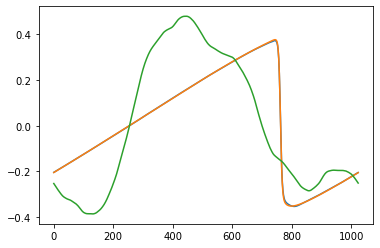

In [88]:
plt.plot(y_train[-1,:].cpu().numpy())

plt.plot(x_train[-1,:].cpu().numpy())


plt.show()

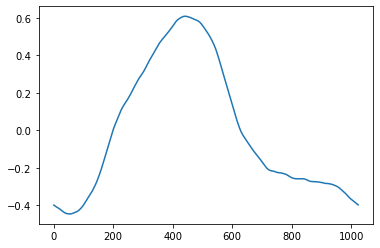

In [196]:
plt.plot(x_test[-1,:,:].cpu().numpy())

In [4]:
PATH = 'fourier_burgers_dt0.002_Modes128'

model = torch.load(PATH)

# Smaller dt=0.02 - Learning

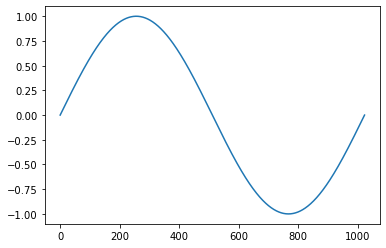

In [101]:
xfield = torch.linspace(0,1,1024)
sinfield = np.sin(2*np.pi*xfield)

plt.plot(sinfield)

sinfield = sinfield.reshape(1,1024,1)
sinfield = sinfield.cuda()

In [102]:
time = []
time.append(sinfield.cpu().detach().numpy())
w = model(sinfield)
time.append(w.cpu().detach().numpy())
for i in range(0,48):
    w = model(w)
    time.append(w.cpu().detach().numpy())
    
timenp = np.array(time)

timenp = timenp[:,-1,:,-1]

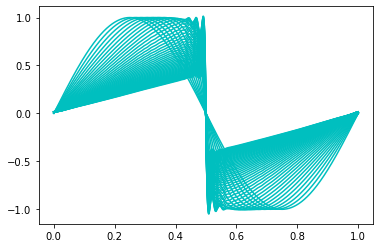

In [103]:
for i in range(0,48): #gibbs phenomenon. why?
    plt.plot(xfield.detach().numpy(), timenp[i,:], 'c')

#plt.plot(X, U[:,:], 'k')    
#plt.show

# Error Analysis

In [182]:
U[:,:].shape
timenp.shape

(50, 1024)

In [291]:
#pointwise error
error = timenp.T - U[:,:] 

In [235]:
error.shape

(1024, 50)

In [94]:
max(error[:,30])

0.24117365010157987

Text(0, 0.5, 'U')

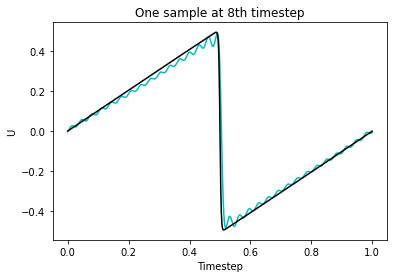

In [292]:
plt.plot(xfield.detach().numpy(), timenp[40,:], 'c')
plt.plot(xfield.detach().numpy(), U[:,40], 'k')

plt.title("One sample at 8th timestep")
plt.xlabel('Timestep')
plt.ylabel('U')

#plt.savefig("Sample_1.png")

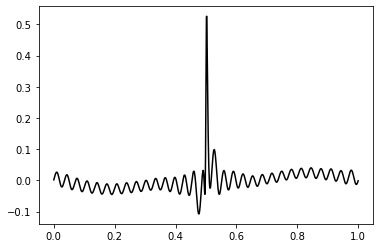

In [295]:
plt.plot(xfield.detach().numpy(), error[:,20], 'k')

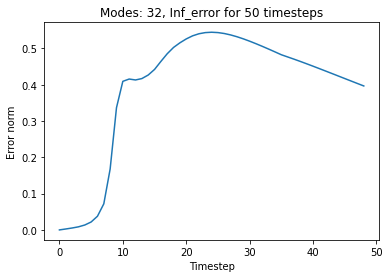

In [293]:
from numpy import linalg as LA

max_error = []
for i in range(0,49):
    max_error.append(LA.norm(error[:,i], np.inf))
    
inf_error = np.array(max_error)

plt.plot(inf_error)
plt.title("Modes: 32, Inf_error for 50 timesteps")
plt.xlabel('Timestep')
plt.ylabel('Error norm')

plt.savefig("Error_2_SimpleSine_32.png")

In [294]:
inf_error[10]

0.4093507347870161

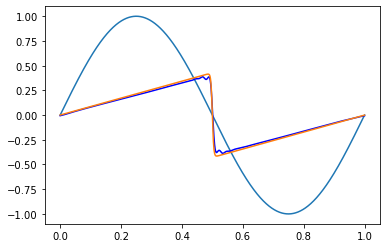

In [254]:
plt.plot(xfield.detach().numpy(), sinfield[-1,:].cpu().detach().numpy()) #I learned with smaller dt=0.02 but it gives gibbs phenomenon
plt.plot(xfield.detach().numpy(), timenp[48,:], 'b')
plt.plot(X, U[:,49])

plt.show()

#Ok, so in this learning there was no capturing of the shock phenomenon. But still, the operator learns the correct
#direction of dynamics and when the shock starts to form, it gives gibbs phenemonon. Maybe, related to the fact
#fourier gives gibbs phenomenon when dealing with sharp functions.

# Try-Low Viscosity

In [62]:
time = []
time.append(sinfield.cpu().detach().numpy())
w = model(sinfield)
time.append(w.cpu().detach().numpy())
for i in range(0,48):
    w = model(w)
    time.append(w.cpu().detach().numpy())
    
timenp = np.array(time)

timenp = timenp[:,-1,:,-1]

In [1]:
plt.plot(xfield.detach().numpy(), timenp[10,:], 'c')
plt.plot(xfield.detach().numpy(), U[:,10], 'k')

plt.title("One sample at 17th timestep")
plt.xlabel('Timestep')
plt.ylabel('U')

#plt.savefig("Sample_1.png")

NameError: name 'plt' is not defined

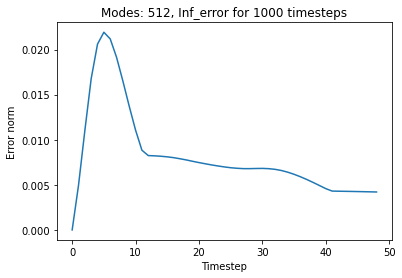

In [65]:
from numpy import linalg as LA

#pointwise error
error = timenp.T - U[:,:] 


#Infinity norm
max_error = []
for i in range(0,49):
    max_error.append(LA.norm(error[:,i], np.inf))
    
inf_error = np.array(max_error)

plt.plot(inf_error)
plt.title("Modes: 512, Inf_error for 1000 timesteps")
plt.xlabel('Timestep')
plt.ylabel('Error norm')

plt.savefig("Error_3_SimpleSine_128_dtpoint1.png")

# Time Plotting - dt = 0.1

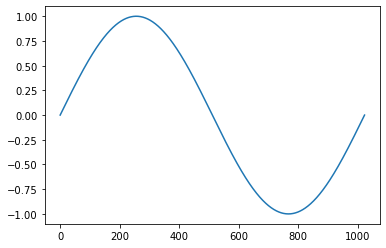

In [70]:
xfield = torch.linspace(0,1,1024)
sinfield = np.sin(2*np.pi*xfield)

plt.plot(sinfield)

sinfield = sinfield.reshape(1,1024,1)
sinfield = sinfield.cuda()

In [92]:
time = []
time.append(sinfield.cpu().detach().numpy())
w = model(sinfield)
time.append(w.cpu().detach().numpy())
#for i in range(0,0):
    #w = model(w)
    #time.append(w.cpu().detach().numpy())
    
timenp = np.array(time)

timenp = timenp[:,-1,:,-1]

#pointwise error
#error = timenp.T - U[:,:] 
error = (pred[-1,:] - y_test[-1,:]) 


#Infinity norm
max_error = []
# for i in range(0,1):
#     max_error.append(LA.norm(error[:,i], np.inf))


max_error = LA.norm(error, np.inf)   
#inf_error = np.array(max_error)

#plt.plot(inf_error)
#plt.title("Modes: 512, Inf_error for 10 timesteps")
#plt.xlabel('Timestep')
#plt.ylabel('Error norm')

#plt.savefig("Error_3_SimpleSine_128_dtpoint1.png")

In [93]:
max_error

0.010261416

In [59]:
error.shape

(1024,)

Text(0, 0.5, 'U')

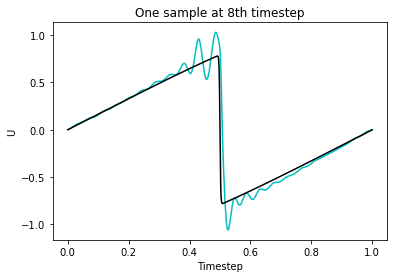

In [322]:
plt.plot(xfield.detach().numpy(), timenp[4,:], 'c')
plt.plot(xfield.detach().numpy(), U[:,4], 'k')

plt.title("One sample at 8th timestep")
plt.xlabel('Timestep')
plt.ylabel('U')

#plt.savefig("Sample_1.png")

In [ ]:
plt.plot(xfield.detach().numpy(), error[:,20], 'k')

# Time Plotting - dt = 1

In [71]:
w = model(sinfield)

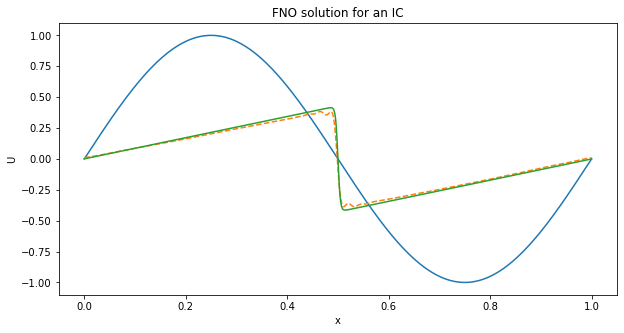

In [110]:
fig = plt.figure(figsize=(10,5))

plt.plot(xfield, sinfield[-1,:].cpu().detach().numpy()) #Comparison for the first timestep
plt.plot(xfield, w[-1,:].cpu().detach().numpy(), '--')
plt.plot(xfield, U[:,-1])
#plt.plot(xfield, U[:,0])

plt.title("FNO solution for an IC")
plt.xlabel('x')
plt.ylabel('U')

plt.savefig('Figures/Burgers2.png')

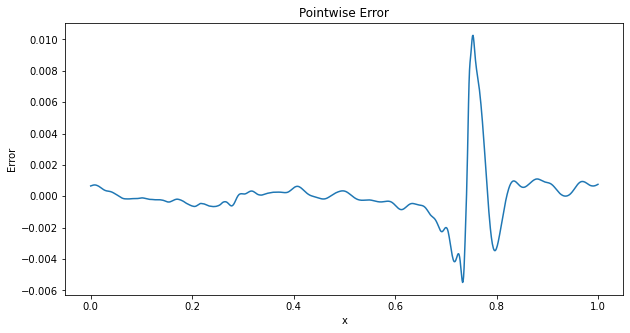

In [94]:
fig = plt.figure(figsize=(10,5))

plt.plot(xfield, error)

plt.title("Pointwise Error")
plt.xlabel('x')
plt.ylabel('Error')

plt.savefig('Figures/ErrorBurger2.png')

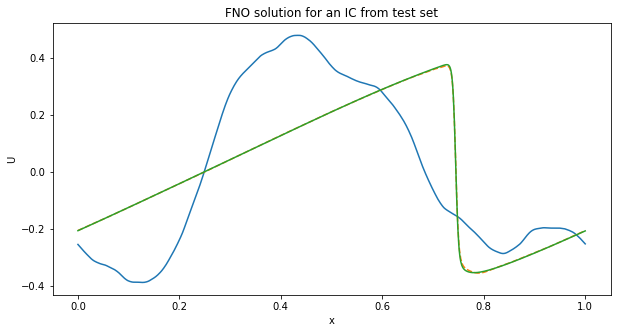

In [111]:
fig = plt.figure(figsize=(10,5))

plt.plot(xfield, x_test[-1,:].cpu().numpy())

plt.plot(xfield, pred[-1,:].cpu().numpy(), '--')

plt.plot(xfield, y_test[-1,:].cpu().numpy())


plt.title("FNO solution for an IC from test set")
plt.xlabel('x')
plt.ylabel('U')

#plt.show()

plt.savefig('Figures/burgers2.png')

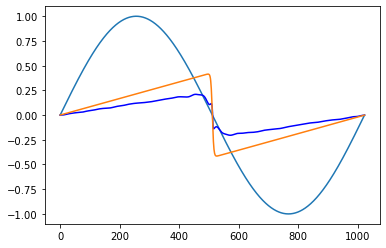

In [27]:
plt.plot(sinfield[-1,:].cpu().detach().numpy()) #Comparison for the second timestep
plt.plot(w[-1,:].cpu().detach().numpy(), 'b')
plt.plot(U[:,-1])

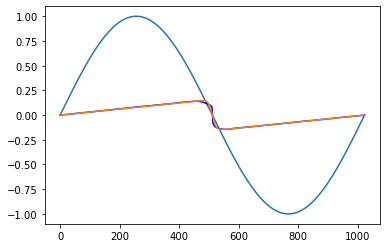

In [172]:
plt.plot(sinfield[-1,:].cpu().detach().numpy()) #Comparison for the third timestep
plt.plot(timenp[2,:], 'b')
plt.plot(U[:,-1])

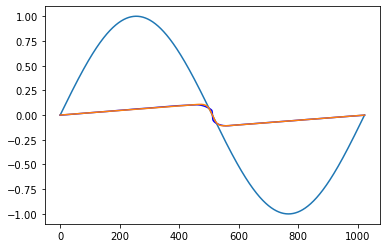

In [174]:
plt.plot(sinfield[-1,:].cpu().detach().numpy()) #Comparison for the third timestep
plt.plot(timenp[3,:], 'b')
plt.plot(U[:,-1])

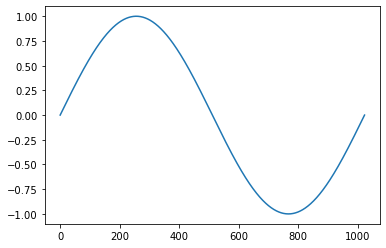

In [263]:
xfield = torch.linspace(0,1,1024)
sinfield = np.sin(2*np.pi*xfield)

plt.plot(sinfield)

sinfield = sinfield.reshape(1,1024,1)
sinfield = sinfield.cuda()

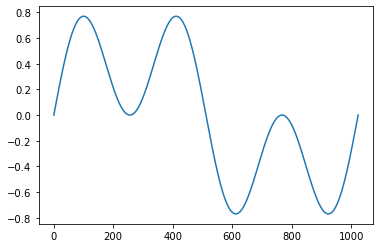

In [13]:
xfield = torch.linspace(0,1,1024)
sinfield = np.sin(4*np.pi*(xfield))*np.cos(2*np.pi*(xfield))

plt.plot(sinfield)

sinfield = sinfield.reshape(1,1024,1)
sinfield = sinfield.cuda()

#plt.savefig("YetAnotherIC.png")

In [158]:
w = model(sinfield)

# Burgers Solution

In [69]:
############## MODULES IMPORTATION ###############
import numpy as np
from scipy.integrate import odeint


############## SET-UP THE PROBLEM ###############

mu = 1
nu = 1/1000 #kinematic viscosity coefficient
    
#Spatial mesh
L_x = 1 #Range of the domain according to x [m]
dx = 1/1024 #Infinitesimal distance
N_x = int(L_x/dx) #Points number of the spatial mesh
X = np.linspace(0,L_x,1024) #Spatial array

#Temporal mesh
L_t = 1 #Duration of simulation [s]
dt = 0.02  #Infinitesimal time
N_t = int(L_t/dt) #Points number of the temporal mesh
T = np.linspace(0,L_t,N_t) #Temporal array

#Wave number discretization
k = 2*np.pi*np.fft.fftfreq(N_x, d = 1/1024)


#Def of the initial condition    
u0 = np.sin(2*np.pi*(X)) #Single space variable fonction that represent the wave form at t = 0
#viz_tools.plot_a_frame_1D(X,u0,0,L_x,0,1.2,'Initial condition')

#u0 = init_data

############## EQUATION SOLVING ###############

#Definition of ODE system (PDE ---(FFT)---> ODE system)
def burg_system(u,t,k,mu,nu):
    #Spatial derivative in the Fourier domain
    u_hat = np.fft.fft(u)
    u_hat_x = 1j*k*u_hat
    u_hat_xx = -k**2*u_hat
    
    #Switching in the spatial domain
    u_x = np.fft.ifft(u_hat_x)
    u_xx = np.fft.ifft(u_hat_xx)
    
    #ODE resolution
    u_t = -mu*u*u_x + nu*u_xx
    return u_t.real
    

#PDE resolution (ODE system resolution)
U = odeint(burg_system, u0, T, args=(k,mu,nu,), mxstep=5000).T


In [11]:
U.shape

(1024, 50)

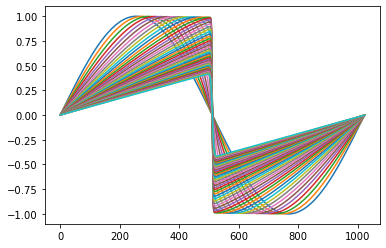

In [18]:
import matplotlib.pyplot as plt
plt.plot(U[:,:])